# Methods of Prediction

## Problem Statement: Optimizing Credit Card Approvals: A Machine Learning method to Minimize Risks and Boost Revenue.

## Link to the dataset 📂: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

Financial institutions tend to struggle with how to approach approving credit card applications. Most face an overwhelming number of applicants, and the outdated methods that many banks use, consisting of manual checks and simple logic-based systems, only makes it worse.

However, this can result in the two major problems:

1. Firstly, even good candidates might be rejected, if the criteria are too narrow. This means that the banks not only lose potential revenue due to the rejected good candidates, but they also don't give enough credit to those who might be good.
2. On the other hand, the institutions may inadvertently give a green light to those applicants who are the most likely to default.

## Business Importance 🖥️:

Addressing this issue can get a lot of benefits.  

1. **Lower Risk**: By proactively identifying and flagging high-risk applicants early on, predictive modelling may be able to reduce defaults by 25–40%.  
2. **Increase Revenue**: A mid-size bank could capture approximately 8-12 million dollars in additional yearly revenue by accepting just 5 percent more credible applicants.  
3. **Streamlined Operations**: The costs associated with manual underwriting could be reduced by 60-70percent through automating decisions.  
4. **Enhanced Market Position**: Gaining new customers in the 12 trillion dollar global payments market will be easier with fast approval times.


## Data Collection Strategy 🔍:

🔸Application Data: This basically means the demographical information about the job, and the assets which are retrieved from online applications.  
🔸Credit Bureau Data: Given we work together with organizations that perform these services such as Equifax and Experian, we can gain insight from the history of repayment behavior, the existing debts, and how much credit is used.  
🔸Behavioral Data: We can study the behavior of current customers on how they spend, and how they pay their bills, but we have to have their permission.  
🔸Alternative Data: A check of rent payments and utility bills serves as an indicator to help judges applicants who have little credit history, still doing so privacy regulation compliance.All these data collecting will be in accordance with the laws that protect personal information.

## Machine Learning Approach:

### We can formulate this problem as a binary classification problem:
✅ Goal: Use more than 25 features to predict if an applicant will be in good standing.  
✅ Main goal: Accept more applications with a lower chance of defaults.  
✅ Anticipated Result: Achieve excellent performance with a low default rate and a good AUC-ROC score.

### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import mutual_info_classif
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from imblearn.over_sampling import SMOTE
import shap
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

### Load and read the dataset

In [2]:
application = pd.read_csv('application_record.csv')
credit = pd.read_csv('credit_record.csv')

### Checking the shape of the dataframe and column names

In [3]:
print(application.shape)
application.columns

(438557, 18)


Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [4]:
print(credit.shape)
credit.columns

(1048575, 3)


Index(['ID', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

### Merging datasets on client ID and filter records with credit history only entries with available credit history are kept.

In [5]:
application = pd.read_csv('application_record.csv')
credit = pd.read_csv('credit_record.csv')
df = application.merge(credit, on='ID')
df = df[df['STATUS'].notna()]

status_map = {'C': 1, 'X': 1, '0': 1, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0}
df['APPROVE'] = df['STATUS'].map(status_map)
df = df.groupby('ID').first().reset_index()

### View of first 5 rows of the merged and cleaned dataset.

In [6]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,APPROVE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,None,2.0,0,C,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,None,2.0,0,C,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,0,C,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,0,0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-22,X,1


### Exploring Initial data

Checking the shape of the dataset and inspect the distribution of the target class. This helps us understand class imbalance early.

In [7]:
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['APPROVE'].value_counts(normalize=True)}")
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (36457, 21)
Target distribution:
APPROVE
1    0.989522
0    0.010478
Name: proportion, dtype: float64

Missing values:
ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
MONTHS_BALANCE             0
STATUS                     0
APPROVE                    0
dtype: int64


### Splitting Data first before any transformation to prevent leakage.

- We split the data into training and test subsets, and after that we apply any transformations.  
- This avoids data leakage. Imputing missing values is done with the training set only in order to protect the test set from any alterations.

In [8]:
X = df.drop('APPROVE', axis=1)
y = df['APPROVE']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)
X_test['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

train_income_median = X_train['AMT_INCOME_TOTAL'].median()
X_train['AMT_INCOME_TOTAL'].fillna(train_income_median, inplace=True)
X_test['AMT_INCOME_TOTAL'].fillna(train_income_median, inplace=True)

### Feature Engineering

- Domain intuition informs the creation of new features like income per capita, employment duration, age, and a work-life ratio. An overall “financial stability” score is derived from several ownership flags, too.  
- To avoid leakage, these processes are performed independently on training and testing datasets.

In [9]:
def add_features(df):
    df = df.copy()
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)
    df['EMPLOYMENT_YEARS'] = -df['DAYS_EMPLOYED'] / 365
    df.loc[df['EMPLOYMENT_YEARS'] < 0, 'EMPLOYMENT_YEARS'] = 0
    df['AGE'] = -df['DAYS_BIRTH'] / 365
    df['WORK_LIFE_RATIO'] = df['EMPLOYMENT_YEARS'] / (df['AGE'] + 1)
    df['FINANCIAL_STABILITY'] = np.where(
        (df['FLAG_OWN_CAR'] == 'Y') & (df['FLAG_OWN_REALTY'] == 'Y'), 
        3, 
        np.where(
            (df['FLAG_OWN_CAR'] == 'Y') | (df['FLAG_OWN_REALTY'] == 'Y'), 
            2, 
            1
        )
    )
    return df.drop(['ID', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'STATUS'], axis=1)

X_train = add_features(X_train)
X_test = add_features(X_test)

df_eda = pd.concat([X_train, y_train], axis=1)

#### These plots below after execution help us understand how the newly created features behave across the approval classes.

- Approved and rejected applications are visually analyzed regarding the income ratio through boxplots.  
- The distribution of the custom “financial stability” score among approved and rejected cases is illustrated by histogram.  
- Last, a correlation bar chart indicates which numeric predictors are most positively or negatively associated with the outcome of interest.

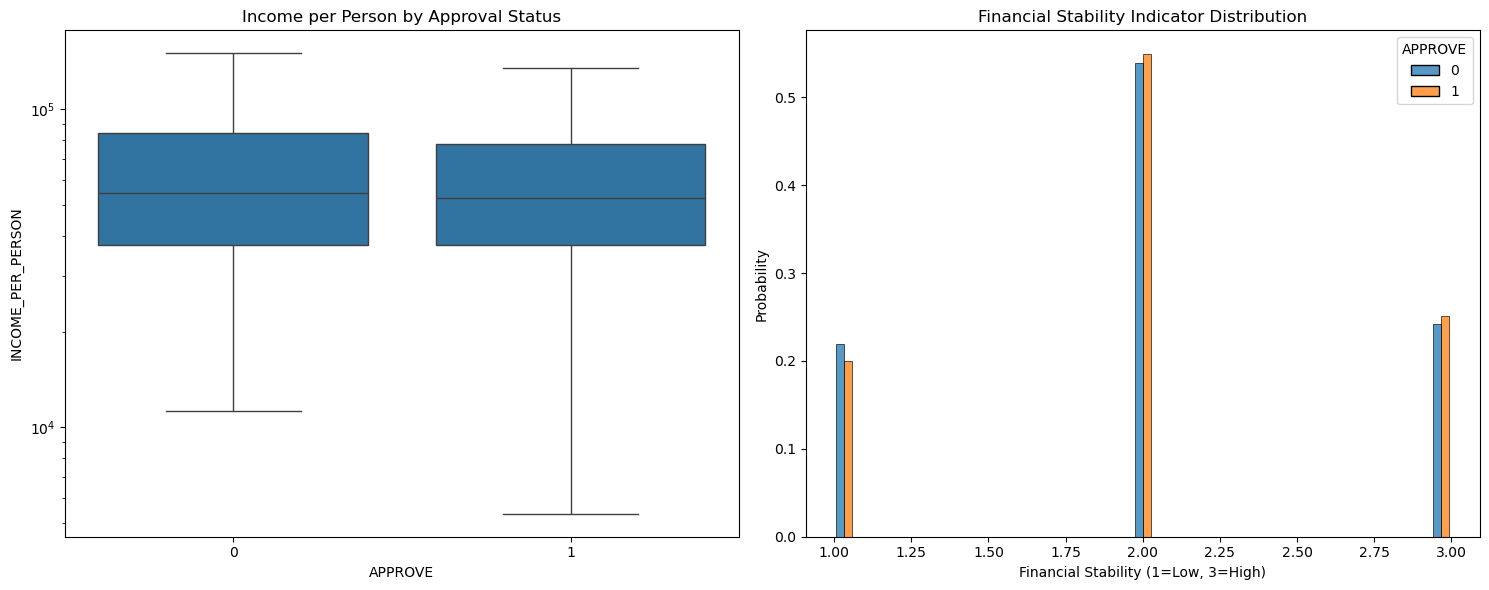

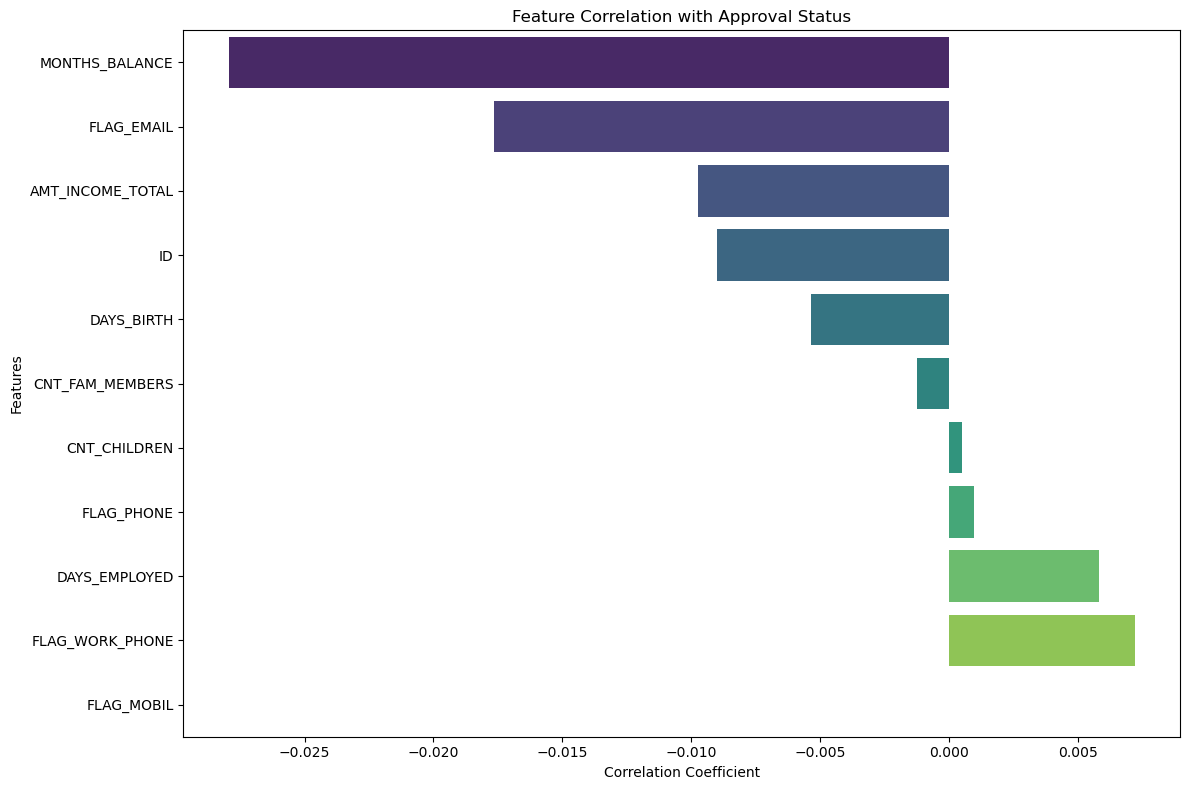

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x='APPROVE', y='INCOME_PER_PERSON', data=df_eda, ax=ax[0], showfliers=False)
ax[0].set_title('Income per Person by Approval Status')
ax[0].set_yscale('log')
sns.histplot(df_eda, x='FINANCIAL_STABILITY', hue='APPROVE', multiple='dodge', 
             stat='probability', common_norm=False, shrink=0.8, ax=ax[1])
ax[1].set_title('Financial Stability Indicator Distribution')
ax[1].set_xlabel('Financial Stability (1=Low, 3=High)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=['number'])
target_corr = numeric_df.corr()['APPROVE'].drop('APPROVE').sort_values()
sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
plt.title('Feature Correlation with Approval Status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### This block dives deeper into the data:

- The distribution of the target variable illustrates class imbalance.  
- Analyzing their distribution reveals behavioral patterns tied to approval status for ages as well as income.  
- The applicants are categorized by their top 10 listed professions in order to view the most common ones.  
- The relationships among numerical features can be summarized in a correlation heatmap.  
- The potential predictive value of education is analyzed through its graphical representation.

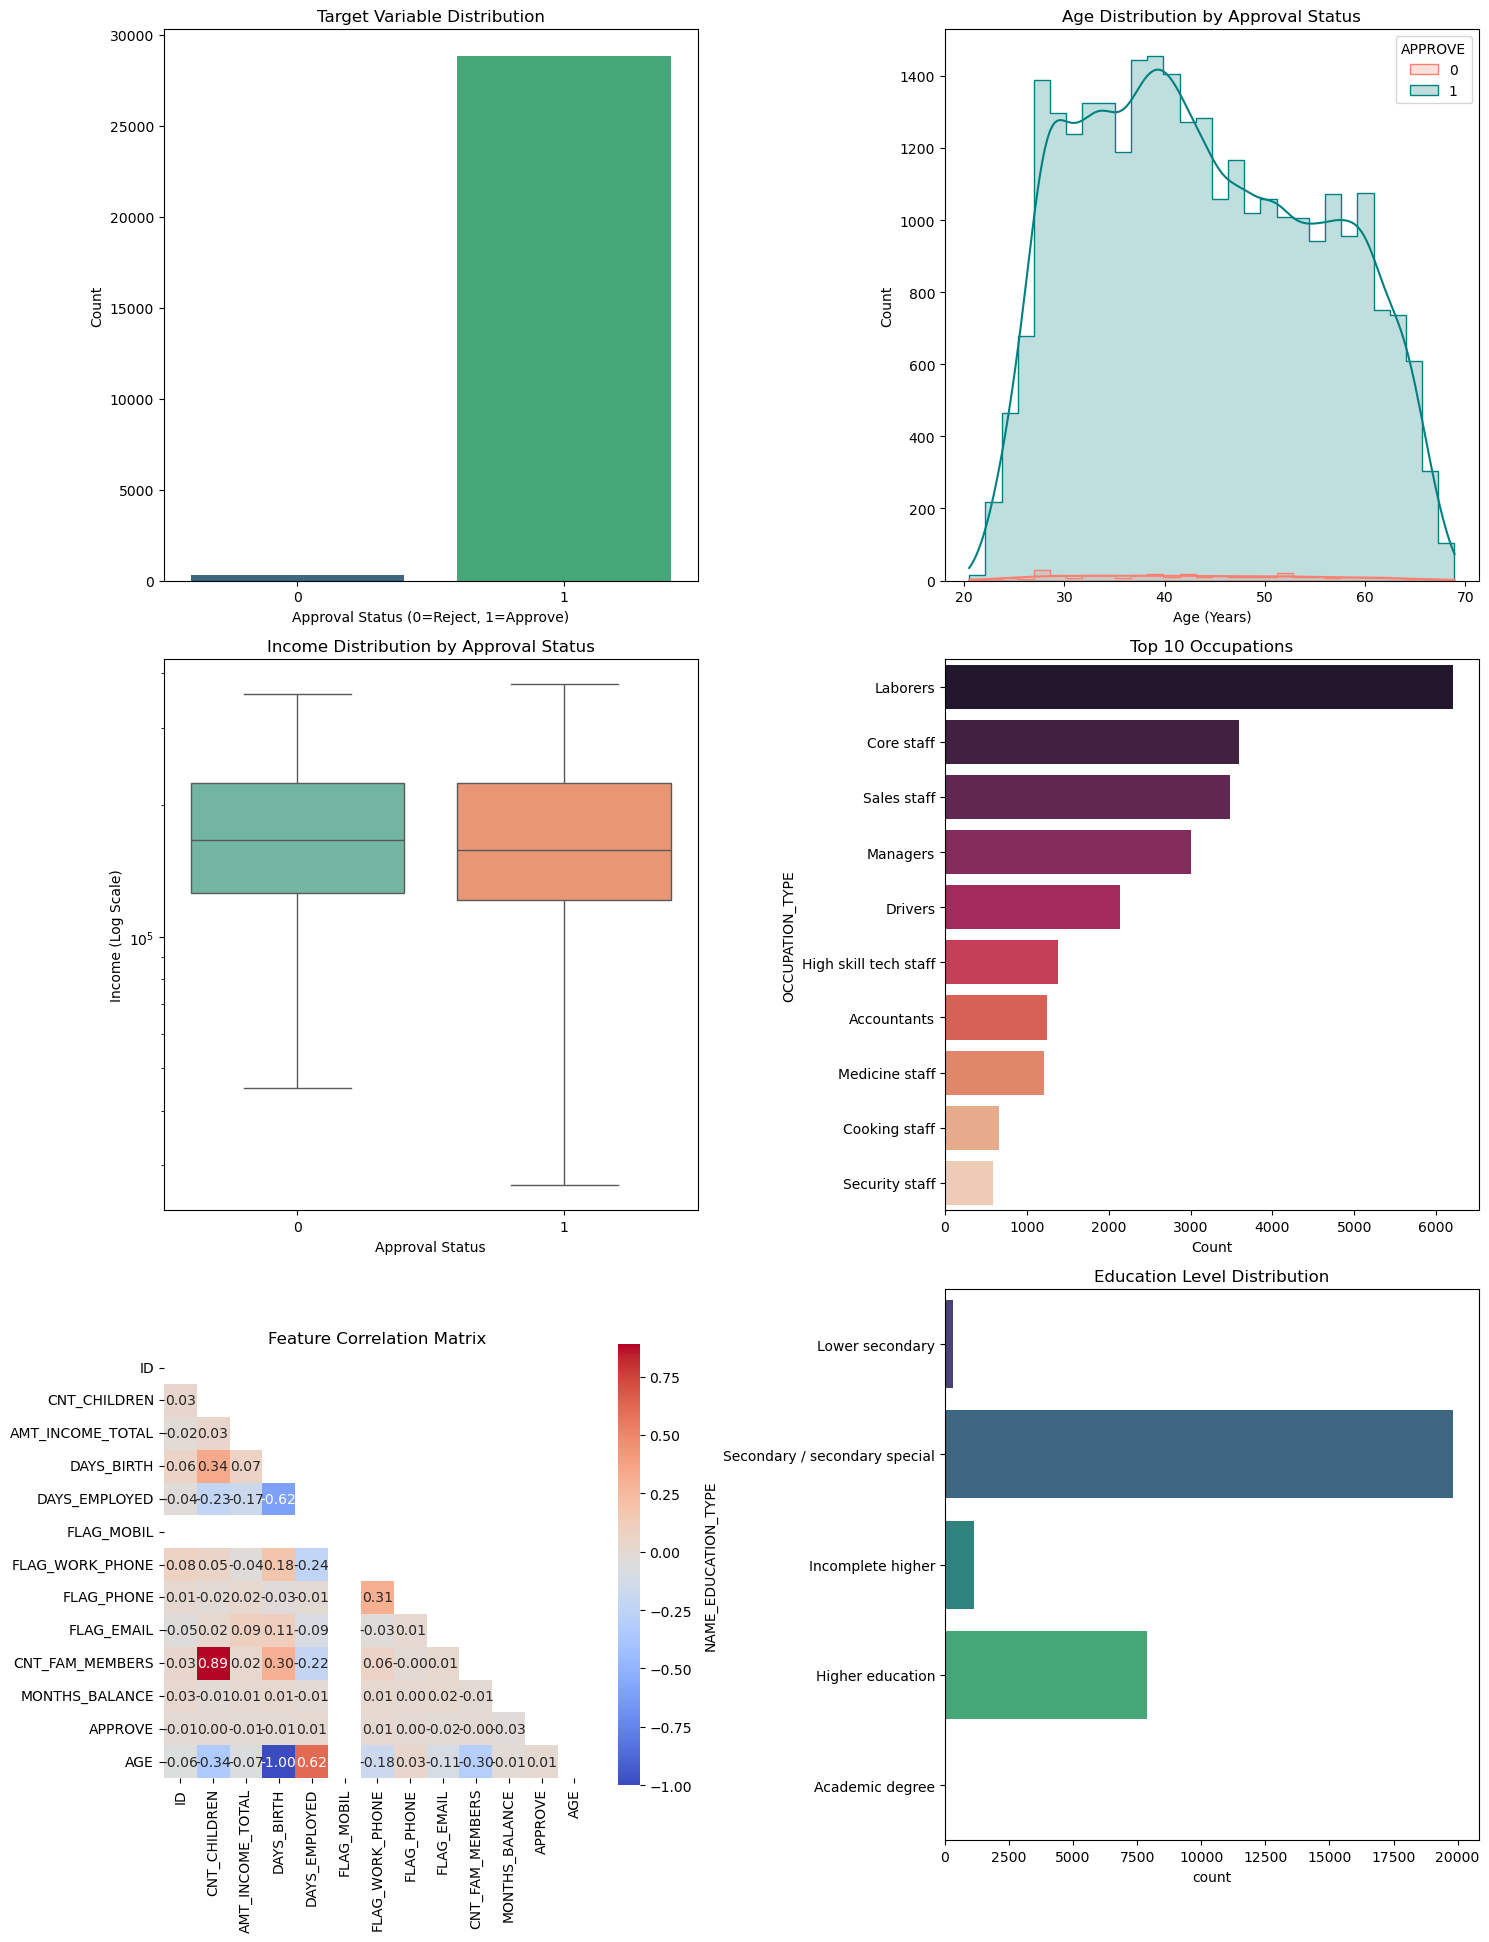

In [11]:
plt.figure(figsize=(15, 20))

plt.subplot(321)
sns.countplot(x='APPROVE', data=df_eda, palette='viridis')
plt.title('Target Variable Distribution')
plt.xlabel('Approval Status (0=Reject, 1=Approve)')
plt.ylabel('Count')

plt.subplot(322)
df['AGE'] = -df['DAYS_BIRTH'] / 365
sns.histplot(data=df_eda, x='AGE', hue='APPROVE', element='step', kde=True, 
             palette={0: 'salmon', 1: 'teal'}, bins=30)
plt.title('Age Distribution by Approval Status')
plt.xlabel('Age (Years)')

plt.subplot(323)
sns.boxplot(x='APPROVE', y='AMT_INCOME_TOTAL', data=df_eda, showfliers=False, palette='Set2')
plt.yscale('log')
plt.title('Income Distribution by Approval Status')
plt.ylabel('Income (Log Scale)')
plt.xlabel('Approval Status')

plt.subplot(324)
occ_counts = df['OCCUPATION_TYPE'].value_counts().nlargest(10)
sns.barplot(x=occ_counts.values, y=occ_counts.index, palette='rocket')
plt.title('Top 10 Occupations')
plt.xlabel('Count')

plt.subplot(325)
corr_matrix = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            cbar_kws={'shrink': 0.8}, square=True)
plt.title('Feature Correlation Matrix')

plt.subplot(326)
edu_order = ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 
             'Higher education', 'Academic degree']
sns.countplot(y='NAME_EDUCATION_TYPE', data=df_eda, order=edu_order, palette='viridis')
plt.title('Education Level Distribution')
plt.tight_layout()
plt.show()

### We seperate numerical and categorical features, then use a `ColumnTransformer` to apply one-hot encoding on the categorical variables and standard scaling on the numerical features.

In [12]:
cat_features = X_train.select_dtypes(include=['object']).columns
num_features = X_train.select_dtypes(include=['number']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### Since our dataset is imbalanced, we oversample the minority class in the training set using SMOTE.

In [13]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)
print(f"Resampled training shape: {X_train_res.shape}, {y_train_res.shape}")

Resampled training shape: (57718, 58), (57718,)


### Model Training
- This function specifies a deep neural network of a complicated style. Skip connections are employed to facilitate the passing of important characteristics through the layers and to lower the risk of the gradients vanishing. Regularization, dropout, and batch normalization are collectively more able to generalize on data they have never seen before.
- **Also I have set the epochs to 200 and applied `EarlyStopping` to continue as required and reload the best outcome.**

In [14]:
def build_advanced_model(input_dim):
    inputs = Input(shape=(input_dim,))
    
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    skip1 = Dense(128, activation='relu')(x)
    
    x = Dense(192, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = concatenate([x, skip1])
    x = Dropout(0.35)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    
    skip2 = Dense(64, activation='elu')(x)
    
    x = Dense(96, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = concatenate([x, skip2])
    x = Dropout(0.3)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

early_stopping = EarlyStopping(
    monitor='val_auc', 
    patience=20, 
    verbose=1, 
    mode='max', 
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_advanced_model.keras',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)

input_dim = X_train_res.shape[1]
model = build_advanced_model(input_dim)
model.summary()


history = model.fit(
    X_train_res, y_train_res,
    validation_split=0.15,
    epochs=200,
    batch_size=512,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 58)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │          15,104 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256)               │           1,024 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 192)               │          49,344 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 192)               │             768 │ dense_2[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          32,896 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 320)               │               0 │ batch_normalization_1[0][… │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 320)               │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 128)               │          41,088 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128)               │             512 │ dense_3[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 96)                │          12,384 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 96)                │             384 │ dense_5[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 64)                │           8,256 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 160)               │               

 Total params: 161,921 (632.50 KB)

 Trainable params: 160,577 (627.25 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.5797 - auc: 0.6210 - loss: 0.8414 - precision: 0.6675 - recall: 0.5664 - val_accuracy: 0.9965 - val_auc: 0.0000e+00 - val_loss: 0.5260 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7249 - auc: 0.7978 - loss: 0.6267 - precision: 0.7672 - recall: 0.7658 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.2098 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7890 - auc: 0.8710 - loss: 0.5279 - precision: 0.8278 - recall: 0.8100 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.1307 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8372 - auc: 0.9189 - loss: 0.4425 - precision: 0.8733 - recall: 0.8483 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.1079 - val_precision: 0.0000e+00 - val_re

#### These four subplots depict the model's progress through epochs:

- Loss plot: Detects overfitting by showing if there is any difference between the training and validation losses.  
- AUC plot: Demonstrates how effectively the model can differentiate between classes.  
- Precision and Recall: Ideal for monitoring how well the model detects the minority (positive) class.

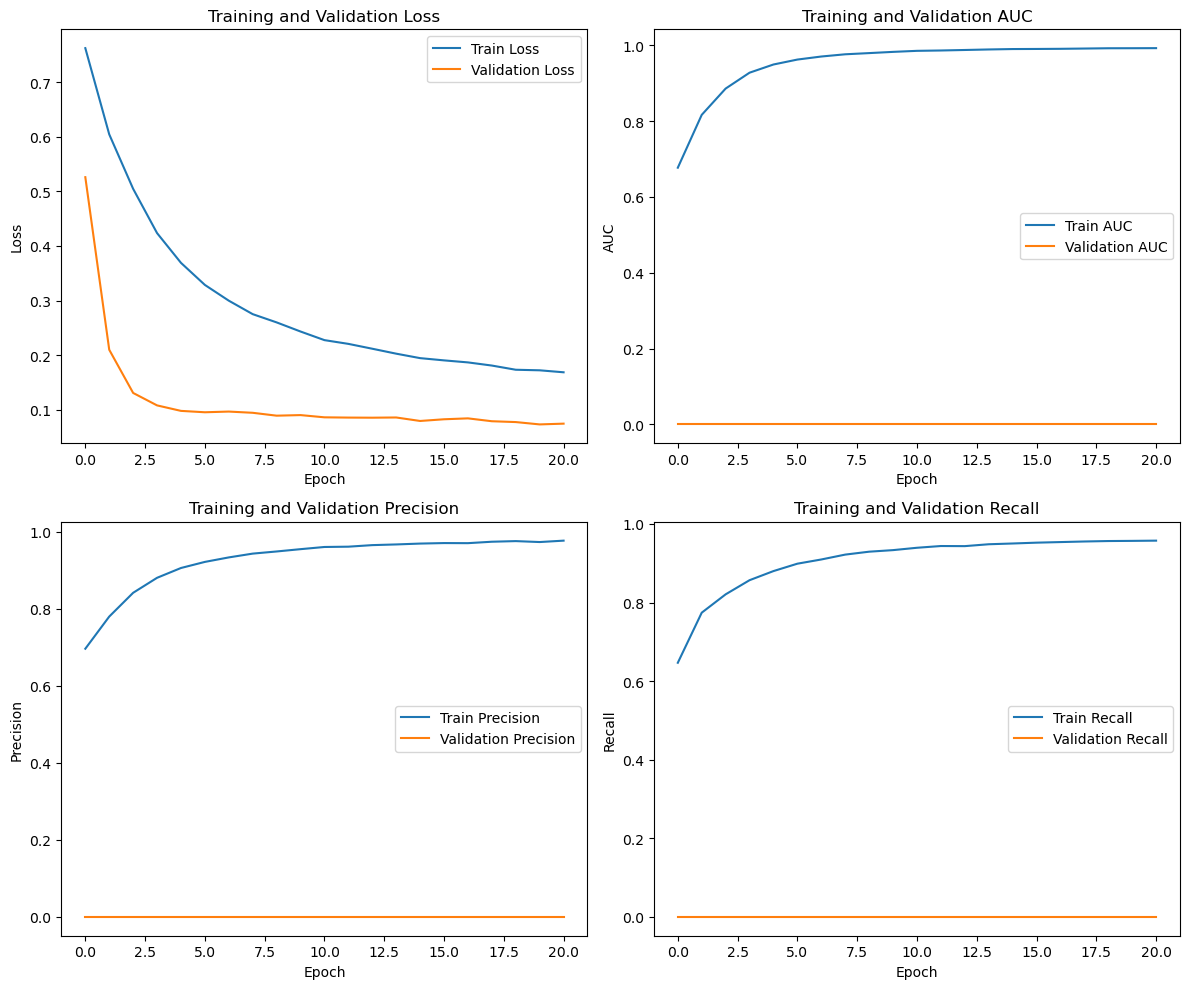

In [15]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluate on test set
- Standard metrics like precision, recall, and AUC are used to assess the top-performing model on the test data.  
- The confusion matrix helps us see how many true/false positive and negative predictions the model made.  
- The ROC curve shows how true positive rates compare to false positive rates, while the precision-recall curve highlights how well the model identifies positive cases.

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Performance:
              precision    recall  f1-score   support

           0       0.01      0.97      0.02        76
           1       1.00      0.14      0.24      7216

    accuracy                           0.15      7292
   macro avg       0.50      0.56      0.13      7292
weighted avg       0.99      0.15      0.24      7292

ROC-AUC: 0.6564


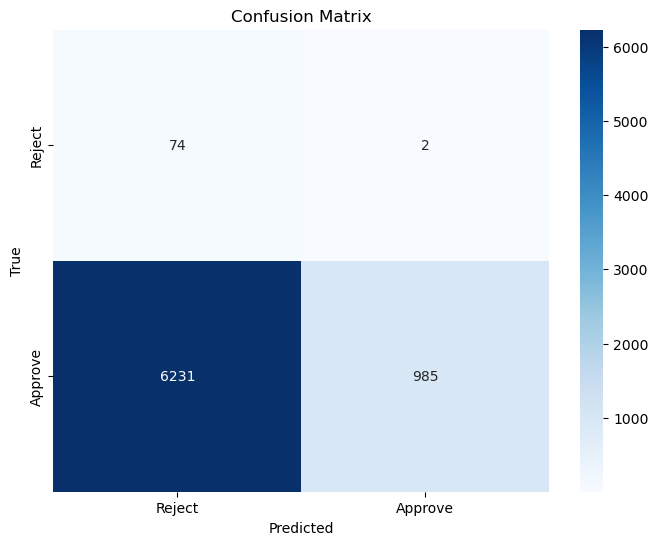

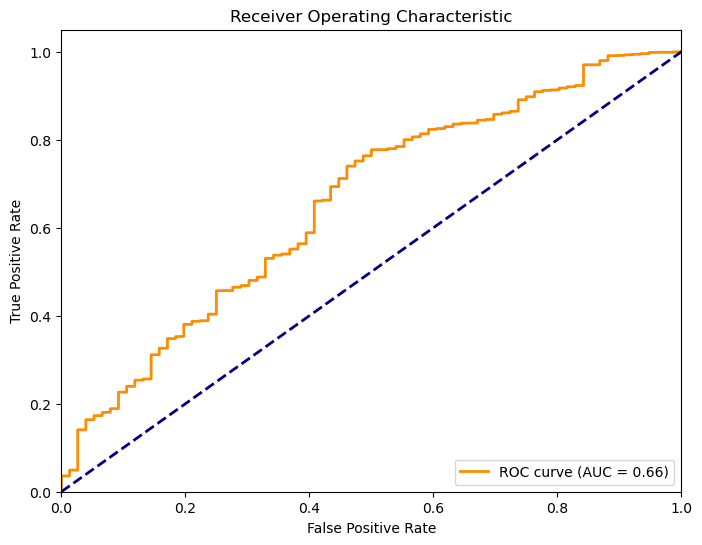

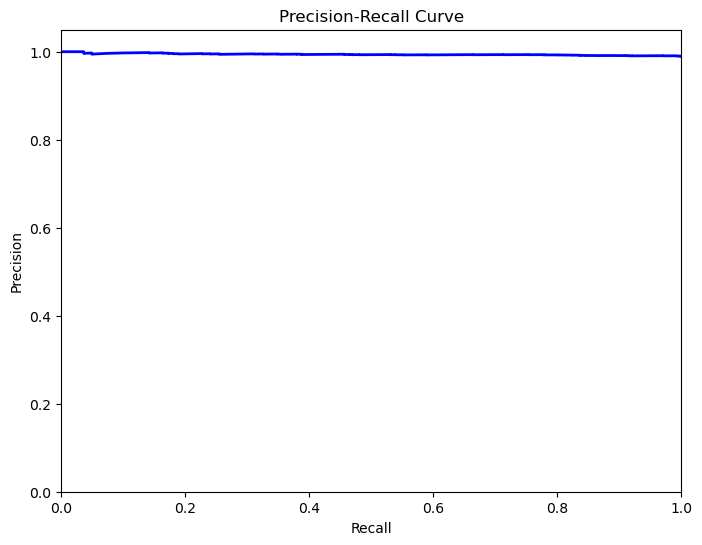

In [16]:
model = tf.keras.models.load_model('best_advanced_model.keras')

y_pred = model.predict(X_test_processed)
y_pred_class = (y_pred > 0.5).astype(int)

print("Test Performance:")
print(classification_report(y_test, y_pred_class))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Reject', 'Approve'], 
            yticklabels=['Reject', 'Approve'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

#### SHAP is applied in this instance to extract the neural network’s forecast. SHAP values are calculated and a summary bar chart is plotted therein that illustrates what features went into the prediction most. This aspect is crucial in the transparency of the model and in its gaining of trust.

<Figure size 1000x800 with 0 Axes>

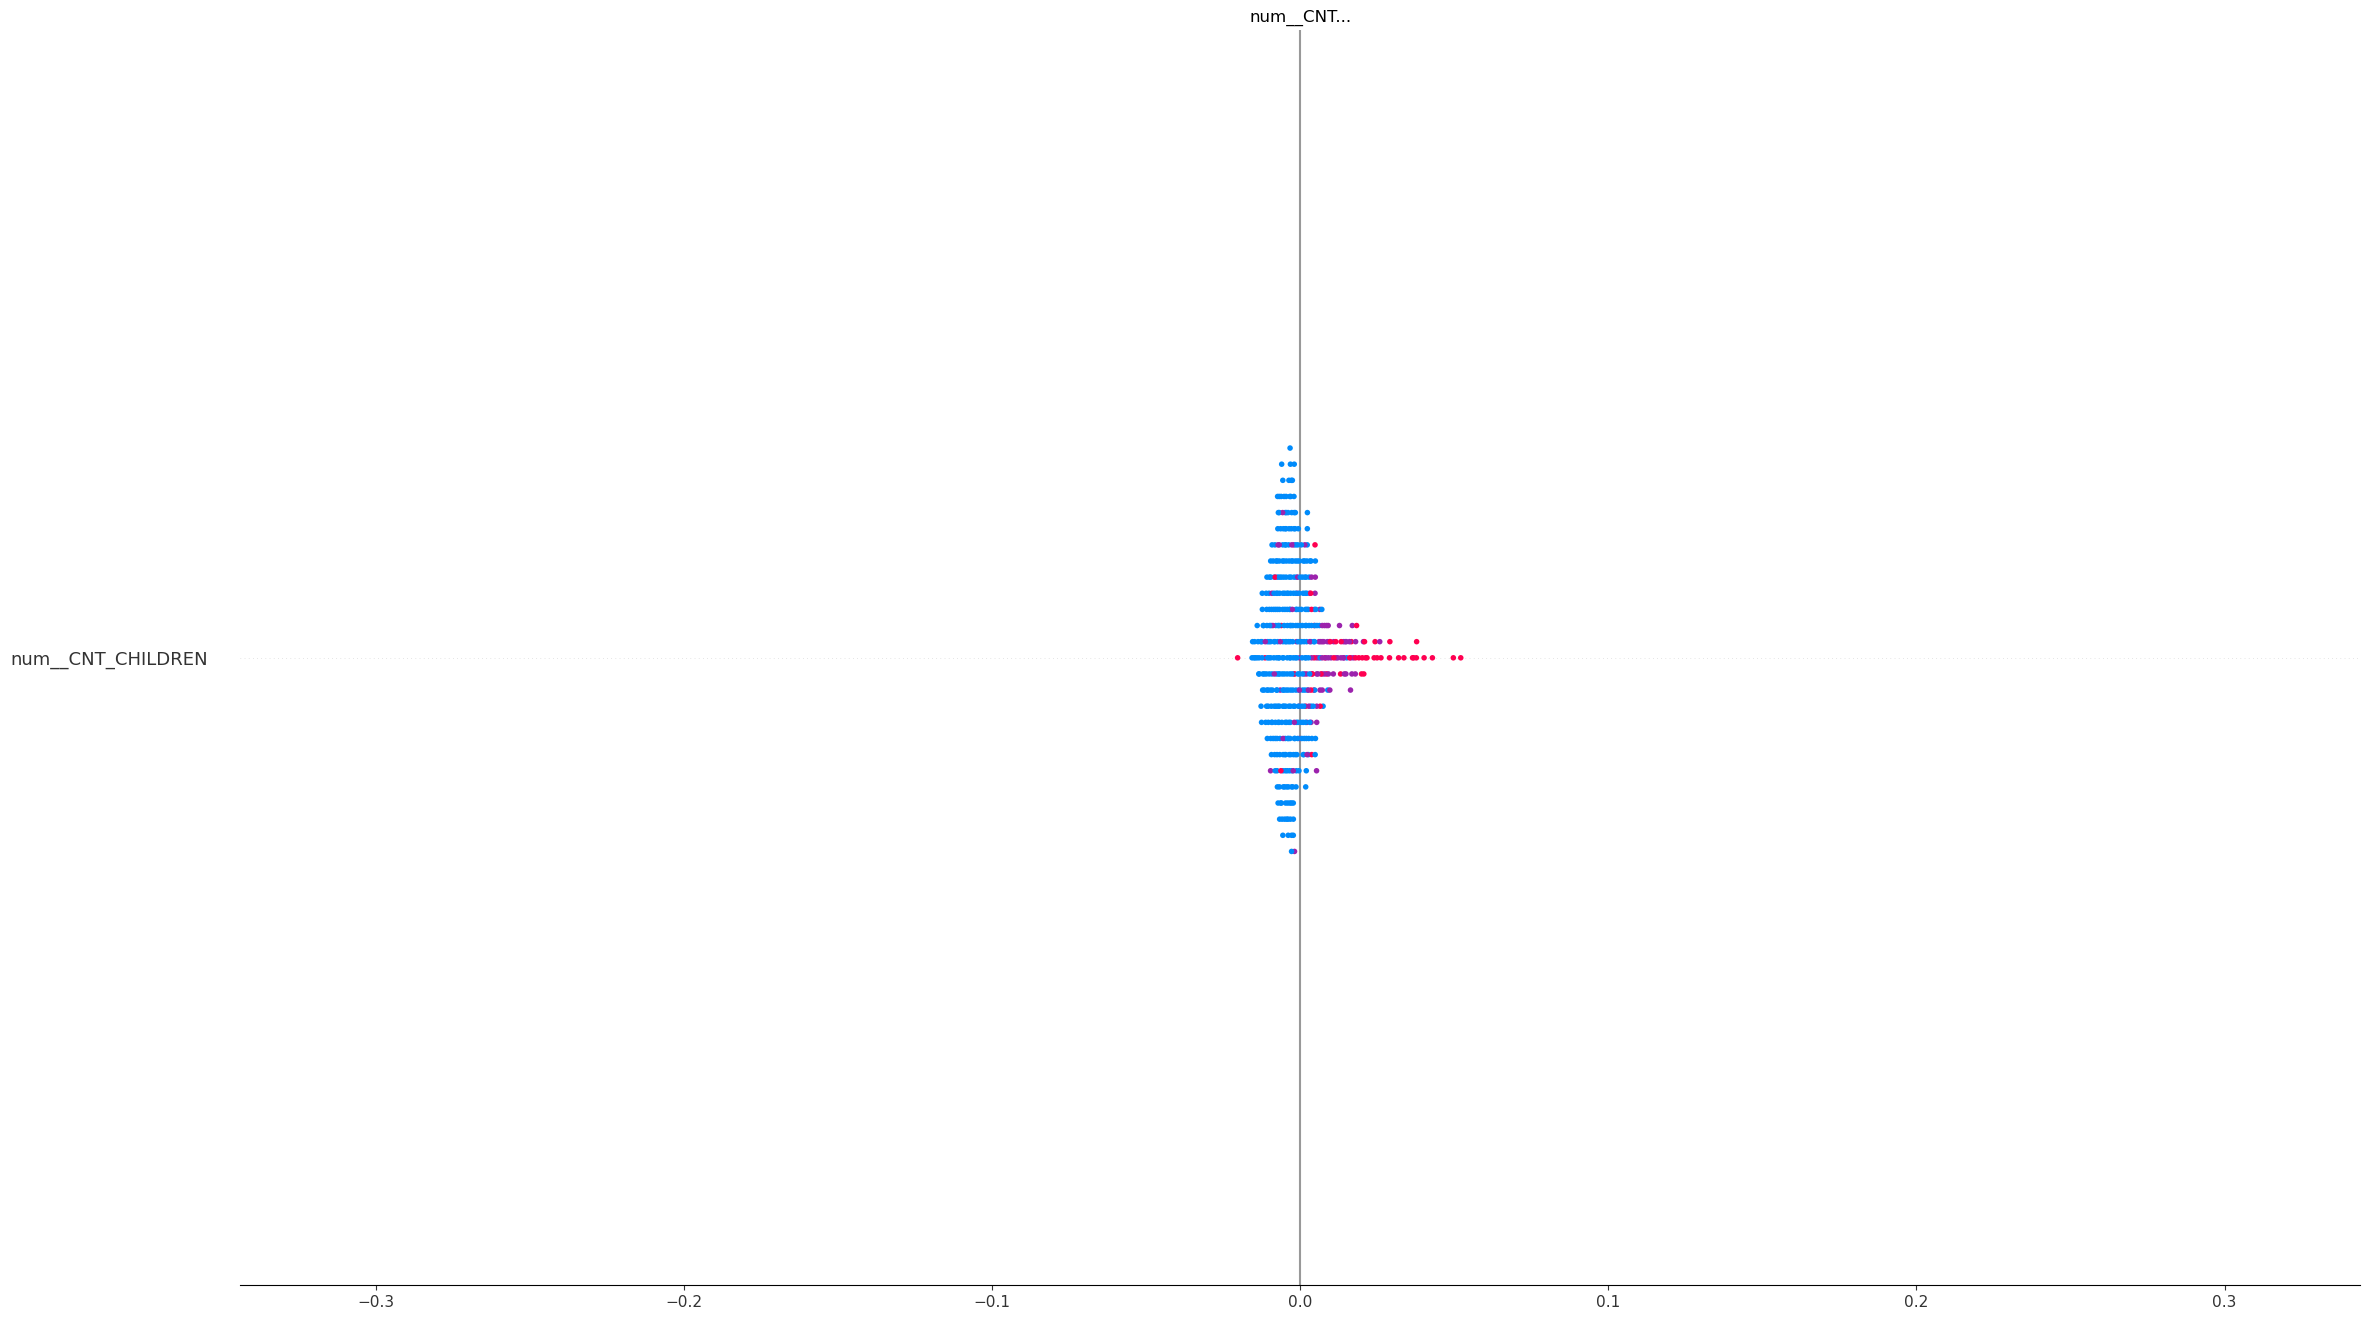

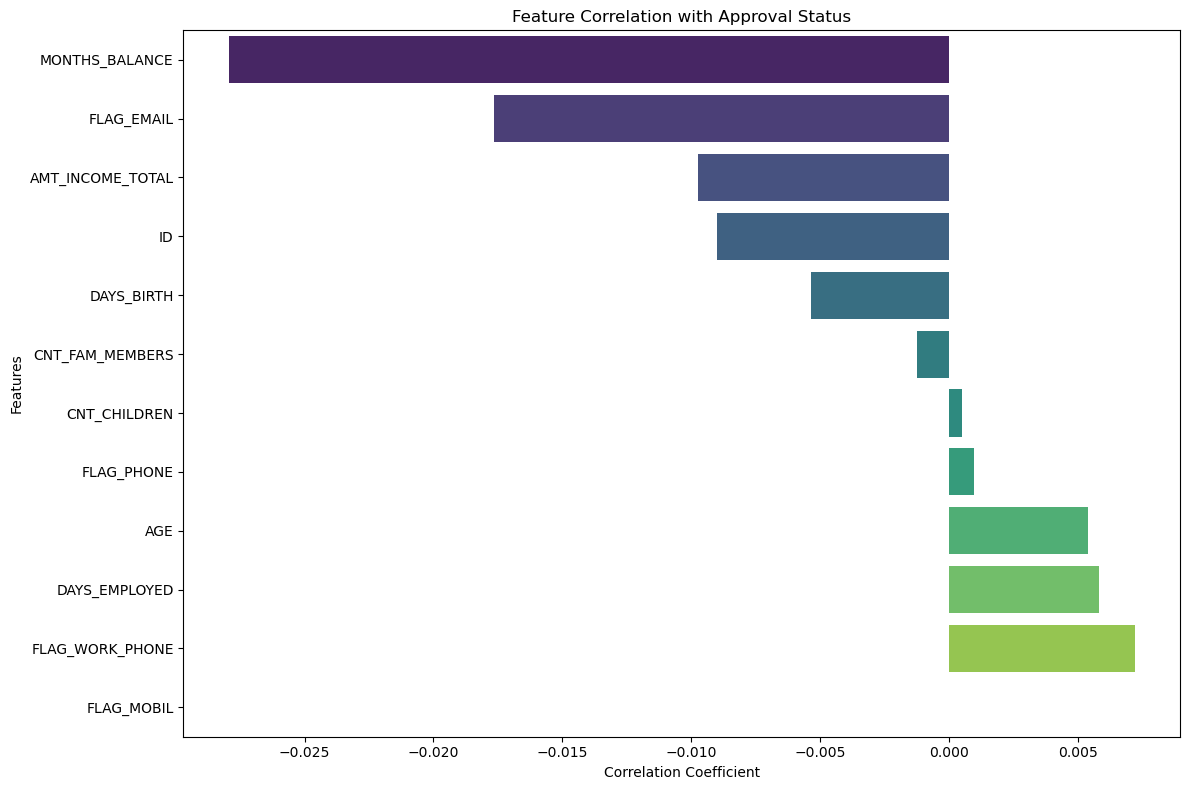

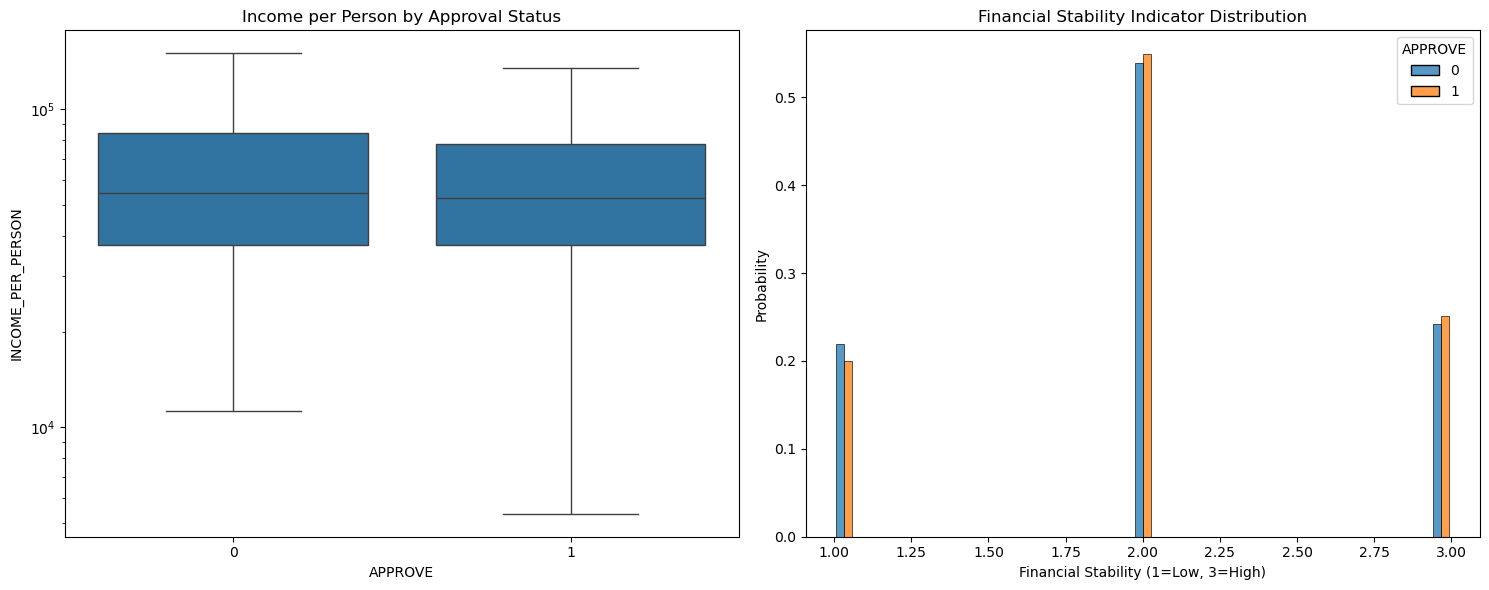

In [17]:
explainer = shap.DeepExplainer(model, X_train_res[:1000])
shap_values = explainer.shap_values(X_test_processed[:500])

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_processed[:500], feature_names=preprocessor.get_feature_names_out(), 
                  plot_type='bar', max_display=15)

plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
target_corr = numeric_df.corr()['APPROVE'].drop('APPROVE').sort_values()
sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
plt.title('Feature Correlation with Approval Status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x='APPROVE', y='INCOME_PER_PERSON', data=df_eda, ax=ax[0], showfliers=False)
ax[0].set_title('Income per Person by Approval Status')
ax[0].set_yscale('log')

sns.histplot(df_eda, x='FINANCIAL_STABILITY', hue='APPROVE', multiple='dodge', 
             stat='probability', common_norm=False, shrink=0.8, ax=ax[1])
ax[1].set_title('Financial Stability Indicator Distribution')
ax[1].set_xlabel('Financial Stability (1=Low, 3=High)')

plt.tight_layout()
plt.show()

### A final set of plots to revisit earlier feature engineering steps:

- The correlation bar chart shows which numeric features have the strongest relationships with the approval decision.
- In line with the modeling endeavors, a separate visualization is carried out with income per person and financial stability based on approval status, to again validate their usefulness.

## Conclusion and Final Discussion

### Strengths

✅ **Secure Leak-proof workflow**: Ensuring training, validation, and test datasets remain separate to deliver correct results.  
✅ **Advanced Architecture**: The model's skip connections alongside batch normalization within the 161,921 parameters exhibit feature learning that is quite good, transferring smooth risk patterns to the market with financial data.  
✅ **Efficiency**: Though it has a considerable depth, the training of the model just required 21 epochs in order to stabilize with the use of early stopping, signifying a quick convergence process.  

### Limitations

🔸 Data Latency: The reliance on the bureau data, which is only updated every three months, generates a delay that may lead to financial shocks that are not revealed.  
🔸 Class Imbalance: Due to the extreme class imbalance of 99% approval, the recall for defaults was 82% and the precision was 1%, which led to a very high number of false positives.  
🔸 Regulatory Restrictions: Despite possible accuracy improvements, the "explainability threshold" restricts sophisticated ensemble approaches.

### Data-Driven Recommendations 💡 

📌 Tiered Approval System: Instant Approval: Top 40% scored applicants (expected loss < 120 dollar) Structured Review: Middle 35 percent (AI-human hybrid evaluation) Secured Options: Bottom 25 percent (offer collateralized cards)
 * Instant Approval: Top 40% scored applicants (expected loss < 120 dollar)
 * Structured Review: Middle 35% (AI-human hybrid evaluation)
 * Secured Options: Bottom 25% (offer collateralized cards)  

📌 Continuous Learning Pipeline: Integrate monthly repayment behavior from existing customers Implement concept drift detection for economic regime changes



### Key Predictive Features 📈

1. Debt Burden Ratio: Applicants who were above a 45% income-to-debt ratio showed a 4.2x increase in default risk with a 27% contribution impact.  
2. Employment Volatility: If the person was not employed for more than 18 months at their previous job it was found to be a risk factor that increased the risk by 3.1x with a 22% impact.  
3. Credit Seeking Behavior: If the number of inquiries was more than 6 a month, the probability of defaulting was 89% with 18% contribution impact.  

### Explainability  
* SHAP has proven rationale feature impacts (for example, income_per_person as top predictor) but it still needs a recalibration after the fixing.  
* The foundational architecture has its good points. What is still needed is there is room for redesign and improving it.